In [22]:
import numpy as np
from scipy.integrate import solve_ivp
from scipy.interpolate import interp1d
import matplotlib.pyplot as plt

In [2]:
gamma = 0.1      
alpha = 0.01    
beta = 0.01      
rho_c = 0.5      
A_max = 2.0     
H_max = 2.0      
T = 20          
dt = 0.1         

t_span = (0,T)
t_eval = np.arange(0, T + dt, dt)

In [10]:
W0 = 1.0
V0 = 1.0
lambda_W0 = 0.26
lambda_V0 = 0.20

In [11]:
def system(t, y):
    W, V, lW, lV = y

    try:
        
        G = gamma * (1 + lV)
        a = np.array([[G, -2 * beta], [1, 0]])
        b = np.array([lW, 2 * alpha])
        sol = np.linalg.solve(a, b)
        A_opt, H_opt = sol
    except np.linalg.LinAlgError:
        A_opt, H_opt = 0, 0

    A_opt = np.clip(A_opt, 0, A_max)
    H_opt = np.clip(H_opt, 0, H_max)

    density_violation = W - rho_c * V
    if density_violation < 0:
        eta = 10.0 
    else:
        eta = 0.0

    dW_dt = A_opt - H_opt
    dV_dt = gamma * A_opt * H_opt
    dlW_dt = -eta
    dlV_dt = eta * rho_c

    return [dW_dt, dV_dt, dlW_dt, dlV_dt]

In [12]:
y0 = [W0, V0, lambda_W0, lambda_V0]
sol = solve_ivp(system, t_span, y0, t_eval=t_eval)
W_sol, V_sol, lambda_W_sol, lambda_V_sol = sol.y
density = W_sol / V_sol

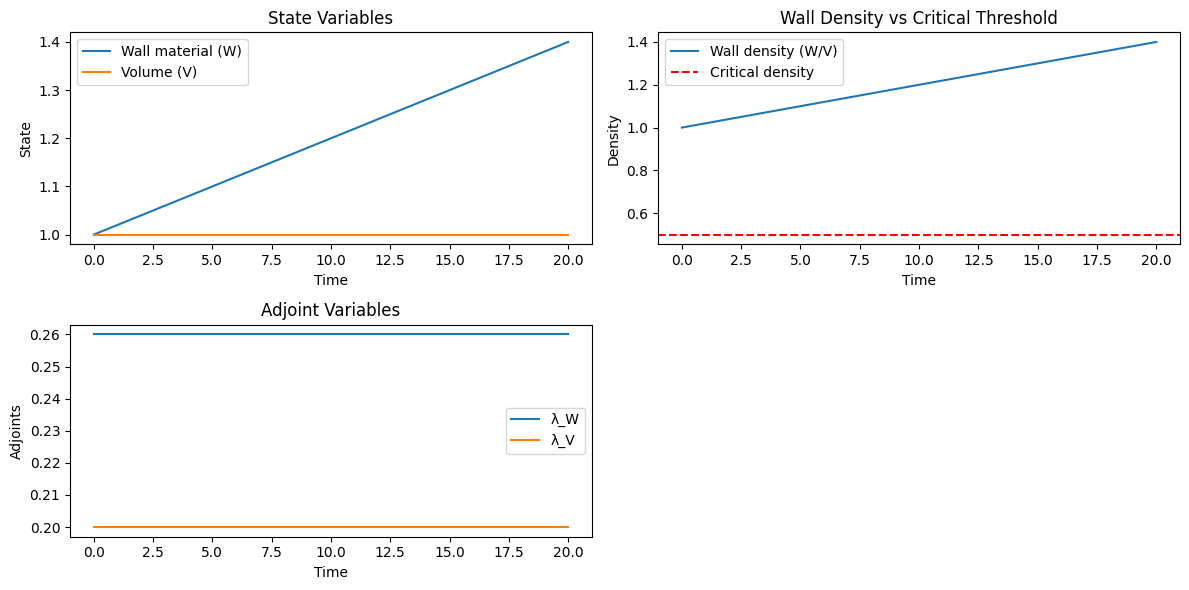

In [13]:
plt.figure(figsize=(12, 6))

plt.subplot(2, 2, 1)
plt.plot(t_eval, W_sol, label='Wall material (W)')
plt.plot(t_eval, V_sol, label='Volume (V)')

plt.legend()
plt.xlabel('Time')
plt.ylabel('State')
plt.title('State Variables')

plt.subplot(2, 2, 2)
plt.plot(t_eval, density, label='Wall density (W/V)')
plt.axhline(rho_c, color='r', linestyle='--', label='Critical density')
plt.legend()
plt.xlabel('Time')
plt.ylabel('Density')
plt.title('Wall Density vs Critical Threshold')

plt.subplot(2, 2, 3)
plt.plot(t_eval, lambda_W_sol, label='λ_W')
plt.plot(t_eval, lambda_V_sol, label='λ_V')
plt.legend()
plt.xlabel('Time')
plt.ylabel('Adjoints')
plt.title('Adjoint Variables')

plt.tight_layout()
plt.show()

In [61]:
def antibiotic_effect(t):
    stress = np.random.rand(*np.shape(t))
    return stress

In [62]:
A_record = []
H_record = []

In [63]:
def system_with_controls_store(t, y):
    W, V, lW, lV = y
    stress = antibiotic_effect(t)

    try:
        G = gamma * (1 + lV)
        a = np.array([[G, -2 * beta], [1, 0]])
        b = np.array([lW, 2 * alpha])
        sol = np.linalg.solve(a, b)
        A_opt, H_opt = sol
    except np.linalg.LinAlgError:
        A_opt, H_opt = 0, 0

    A_opt = np.clip(A_opt * (1 - 0.8 * stress), 0, A_max)
    H_opt = np.clip(H_opt * (1 + 1.5 * stress), 0, H_max)

    density_violation = W - rho_c * V
    eta = 10.0 if density_violation < 0 else 0.0

    dW_dt = A_opt - H_opt
    dV_dt = gamma * A_opt * H_opt
    dlW_dt = -eta
    dlV_dt = eta * rho_c

    A_record.append((t, A_opt))
    H_record.append((t, H_opt))

    return [dW_dt, dV_dt, dlW_dt, dlV_dt]

In [64]:
sol = solve_ivp(system_with_controls_store, t_span, y0, t_eval=t_eval)

W_sol, V_sol, lambda_W_sol, lambda_V_sol = sol.y
density = W_sol / V_sol

A_times, A_values = zip(*A_record)
H_times, H_values = zip(*H_record)

A_interp = interp1d(A_times, A_values, bounds_error=False,
                    fill_value="extrapolate")
H_interp = interp1d(H_times, H_values, bounds_error=False,
                    fill_value="extrapolate")

A_eval = A_interp(t_eval)
H_eval = H_interp(t_eval)

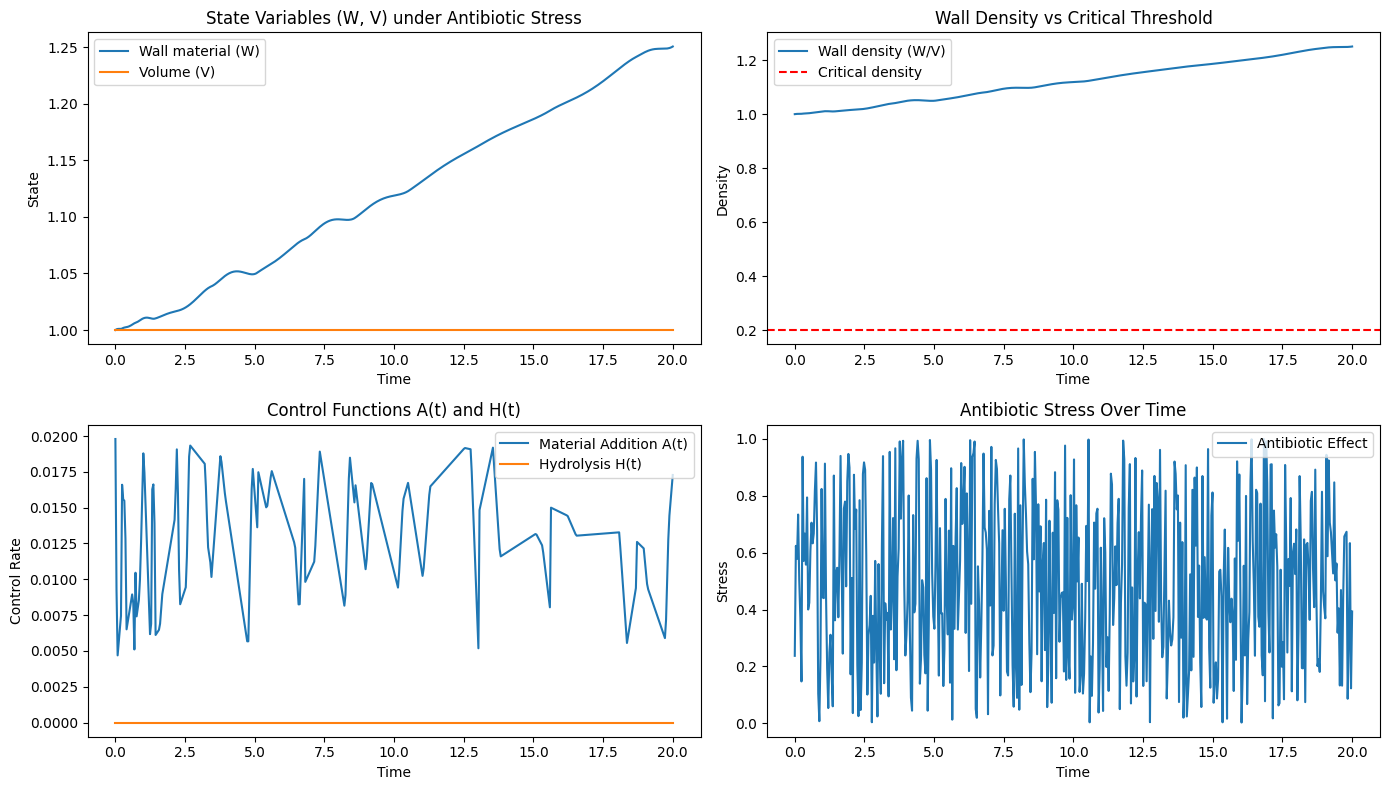

In [65]:
plt.figure(figsize=(14, 8))

plt.subplot(2, 2, 1)
plt.plot(t_eval, W_sol, label='Wall material (W)')
plt.plot(t_eval, V_sol, label='Volume (V)')
plt.legend()
plt.xlabel('Time')
plt.ylabel('State')
plt.title('State Variables (W, V) under Antibiotic Stress')

plt.subplot(2, 2, 2)
plt.plot(t_eval, density, label='Wall density (W/V)')
plt.axhline(rho_c, color='r', linestyle='--', label='Critical density')
plt.legend()
plt.xlabel('Time')
plt.ylabel('Density')
plt.title('Wall Density vs Critical Threshold')

plt.subplot(2, 2, 3)
plt.plot(t_eval, A_eval, label='Material Addition A(t)')
plt.plot(t_eval, H_eval, label='Hydrolysis H(t)')
plt.legend()
plt.xlabel('Time')
plt.ylabel('Control Rate')
plt.title('Control Functions A(t) and H(t)')

plt.subplot(2, 2, 4)
plt.plot(t_eval, antibiotic_effect(t_eval), label='Antibiotic Effect')
plt.xlabel('Time')
plt.ylabel('Stress')
plt.title('Antibiotic Stress Over Time')
plt.legend()

plt.tight_layout()
plt.show()